In [1]:
import json
import os
import pickle
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import obspy
import pandas as pd
from obspy.clients.fdsn import Client


Number of events: 252


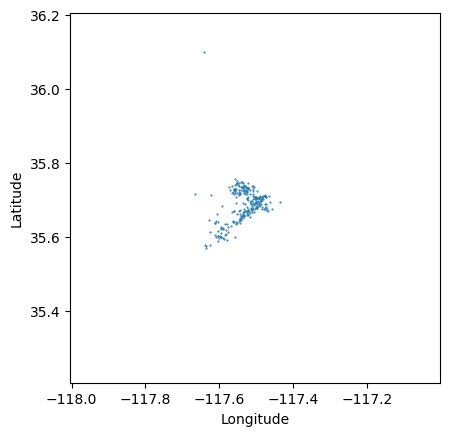

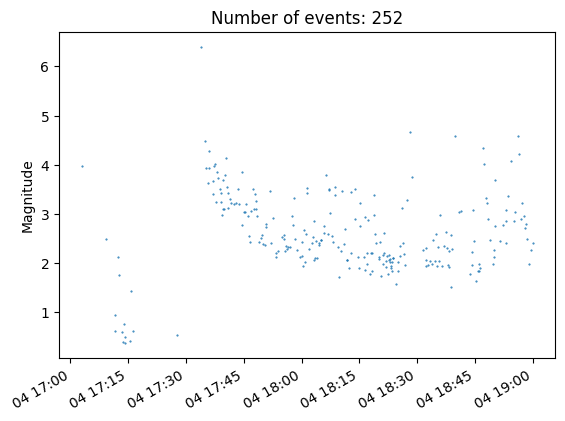

In [2]:

# matplotlib.use("agg")
# %matplotlib inline
os.makedirs("events", exist_ok=True)

config_json= 'config/config.json'

try:
    with open(config_json, "r") as fp:
        config = json.load(fp)
except Exception as err:
    print(f"ERROR: Failed to open or parse {config_json}\n{err}")
    raise

####### IRIS catalog ########
try:
    events = Client(config["client"]).get_events(
        starttime=config["starttime"],
        endtime=config["endtime"],
        minlongitude=config["xlim_degree"][0],
        maxlongitude=config["xlim_degree"][1],
        minlatitude=config["ylim_degree"][0],
        maxlatitude=config["ylim_degree"][1],
        # filename='events.xml',
    )
except:
    events = Client("iris").get_events(
        starttime=config["starttime"],
        endtime=config["endtime"],
        minlongitude=config["xlim_degree"][0],
        maxlongitude=config["xlim_degree"][1],
        minlatitude=config["ylim_degree"][0],
        maxlatitude=config["ylim_degree"][1],
        # filename='events.xml',
    )

#     events = obspy.read_events('events.xml')
print(f"Number of events: {len(events)}")
#     events.plot('local', outfile="events.png")
#     events.plot('local')

standard_catalog = "events/standard_catalog.csv"
####### Save catalog ########
catalog = defaultdict(list)
for event in events:
    if len(event.magnitudes) > 0:
        catalog["time"].append(event.origins[0].time.datetime)
        catalog["magnitude"].append(event.magnitudes[0].mag)
        catalog["longitude"].append(event.origins[0].longitude)
        catalog["latitude"].append(event.origins[0].latitude)
        catalog["depth(m)"].append(event.origins[0].depth)
catalog = pd.DataFrame.from_dict(catalog).sort_values(["time"])
catalog.to_csv(
    standard_catalog,
    # sep="\t",
    index=False,
    float_format="%.3f",
    date_format="%Y-%m-%dT%H:%M:%S.%f",
    columns=["time", "magnitude", "longitude", "latitude", "depth(m)"],
)



####### Plot catalog ########
plt.figure()
plt.plot(catalog["longitude"], catalog["latitude"], ".", markersize=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("scaled")
plt.xlim(config["xlim_degree"])
plt.ylim(config["ylim_degree"])
plt.savefig("events/Sevents_loc.png")
plt.show()

plt.figure()
plt.plot_date(catalog["time"], catalog["magnitude"], ".", markersize=1)
plt.gcf().autofmt_xdate()
plt.ylabel("Magnitude")
plt.title(f"Number of events: {len(events)}")
plt.savefig("events/events_mag_time.png")
plt.show()

In [3]:
# Kubeflow Pipelines UI用のメタデータ出力
if os.environ.get('ELYRA_RUNTIME_ENV') == 'kfp':
    # For information about Elyra environment variables refer to
    # https://elyra.readthedocs.io/en/stable/user_guide/best-practices-file-based-nodes.html#proprietary-environment-variables

    metadata = {
        'outputs': [
            {
                'storage': 'inline',
                'source': f'# Download Event Complete\n',
                'type': 'markdown',
            }
        ]
    }

    with open('mlpipeline-ui-metadata.json', 'w') as f:
        json.dump(metadata, f)